# Yelp Dataset Challenge

In [45]:
import json
import ast
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import altair as alt
alt.data_transformers.enable('default', max_rows=None)
alt.renderers.enable('notebook')
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import init
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import SGDClassifier
import random
import numpy as np
import time
import random
from sklearn.metrics import f1_score
from collections import defaultdict
import torch.nn.functional as F

In [62]:
neighborhoods = {}
cities = {}
states = {}
postal_codes = {}
latitudes = {}
longitudes = {}
stars = {}
review_count = {}
alcohol = {}
bike_parking = {}
accepts_credit_cards = {}
caters = {}
drivethru = {}
goodforkids = {}
hastv = {}
noise_level = {}
outdoor_seating = {}
restuarants_price_range = {} 
delivery = {}
goodforgroups = {}
pricerange = {}
reservations = {}
table_service = {}
takeout = {}
wifi = {}

## Parse the business file

In [63]:
business_mappings = {}
with open('yelp_academic_dataset_business.json', 'r') as f:
    for i, line in enumerate(f):
        d = json.loads(line)
        attributes = d['attributes']
        if attributes != None:
            business_id = d['business_id'].encode('utf-8')      
            neighborhoods[business_id] = d['neighborhood'].encode('utf-8')
            city = d['city'].encode('utf-8')
            state = d['state'].encode('utf-8')
            cities[business_id] = city
            states[business_id] = state

            postal_codes[business_id] = d['postal_code'].encode('utf-8')
            latitude = d['latitude']
            if latitude == None:
                latitude = -1
            latitudes[business_id] = latitude

            longitude = d['longitude']
            if longitude == None:
                longitude = -1
            longitudes[business_id] = longitude
            star_rating = float(d['stars'])
            stars[business_id] = star_rating

            review_count[business_id] = float(d['review_count'])
            
            if "Alcohol" in attributes:
                alcohol[business_id] = attributes["Alcohol"].encode('utf-8')
            else:
                alcohol[business_id] = -1
            if "BikeParking" in attributes:
                bike_parking[business_id] = attributes["BikeParking"].encode('utf-8')
            else:
                bike_parking[business_id] = -1
            if "BusinessAcceptsCreditCards" in attributes:
                accepts_credit_cards[business_id] = attributes["BusinessAcceptsCreditCards"].encode('utf-8')
            else:
                accepts_credit_cards[business_id] = -1
            if "Caters" in attributes:
                caters[business_id] = attributes["Caters"].encode('utf-8')
            else:
                caters[business_id] = -1
            if "GoodForKids" in attributes:
                goodforkids[business_id] = attributes["GoodForKids"].encode('utf-8')
            else:
                goodforkids[business_id] = -1
            if "DriveThru" in attributes:
                drivethru[business_id] = attributes["DriveThru"].encode('utf-8')
            else:
                drivethru[business_id] = -1
            if "HasTV" in attributes:
                hastv[business_id] = attributes["HasTV"].encode('utf-8')
            else:
                hastv[business_id] = -1
            if "NoiseLevel" in attributes:
                noise_level[business_id] = attributes["NoiseLevel"].encode('utf-8')
            else:
                noise_level[business_id] = -1
            if "OutdoorSeating" in attributes:
                outdoor_seating[business_id] = attributes["OutdoorSeating"].encode('utf-8')
            else:
                outdoor_seating[business_id] = -1
            if "RestaurantPriceRange" in attributes:
                restuarants_price_range[business_id] = attributes["RestaurantPriceRange"].encode('utf-8')
            else:
                restuarants_price_range[business_id] = -1
            if "RestaurantsDelivery" in attributes:
                delivery[business_id] = attributes["RestaurantsDelivery"].encode('utf-8')
            else:
                delivery[business_id] = -1
            if "RestaurantsGoodForGroups" in attributes:
                goodforgroups[business_id] = attributes["RestaurantsGoodForGroups"].encode('utf-8')
            else:
                goodforgroups[business_id] = -1
            if "RestaurantsPriceRange2" in attributes:
                pricerange[business_id] = attributes["RestaurantsPriceRange2"].encode('utf-8')
            else:
                pricerange[business_id] = -1
            if "RestaurantsReservations" in attributes:
                reservations[business_id] = attributes["RestaurantsReservations"].encode('utf-8')
            else:
                reservations[business_id] = -1
            if "RestaurantsTableService" in attributes:
                table_service[business_id] = attributes["RestaurantsTableService"].encode('utf-8')
            else:
                table_service[business_id] = -1
            if "RestaurantsTakeOut" in attributes:
                takeout[business_id] = attributes["RestaurantsTakeOut"].encode('utf-8')
            else:
                takeout[business_id] = -1
            if "WiFi" in attributes:
                wifi[business_id] = attributes["WiFi"].encode('utf-8')
            else:
                wifi[business_id] = -1

## Printing some stats about the dataset

In [4]:
cities_set = set(cities.values())
states_set = set(states.values())
postal_codes_set = set(postal_codes.values())
print("Number of cities: " + str(len(cities_set)))
print("Number of states: " + str(len(states_set)))
print("Number of postal codes: " + str(len(postal_codes)))

Number of cities: 1033
Number of states: 65
Number of postal codes: 162807


Average start rating: 3.6606380561


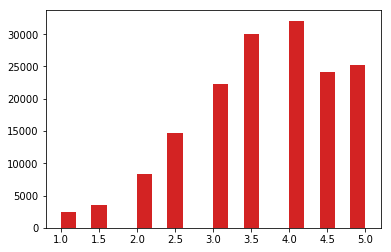

In [5]:
print("Average start rating: " + str(sum(stars.values())/len(stars.values())))
plt.hist(stars.values(), 20, color='#D32323')
plt.plot()
plt.show()

### Getting business features

In [6]:
mappings = [neighborhoods, cities, states, postal_codes, alcohol, bike_parking, accepts_credit_cards, caters, drivethru, goodforkids, hastv, noise_level, outdoor_seating, restuarants_price_range, delivery, goodforgroups, pricerange, reservations, table_service, takeout, wifi]
categorical_mappings = []
for mapping in mappings:           
    sorted_map = {}
    map_values = set(mapping.values())
    sorted_var_set = sorted(map_values)
    for value in map_values:
        sorted_map[value] = sorted_var_set.index(value)
    categorical_mappings.append(sorted_map)

In [7]:
def get_feature_vector(business_id):
    feature_vector = []
    feature_vector.append(categorical_mappings[0][neighborhoods[business_id]])
    feature_vector.append(categorical_mappings[1][cities[business_id]])
    feature_vector.append(categorical_mappings[2][states[business_id]])
    feature_vector.append(categorical_mappings[3][postal_codes[business_id]])
    feature_vector.append(categorical_mappings[4][alcohol[business_id]])
    feature_vector.append(latitudes[business_id])
    feature_vector.append(longitudes[business_id])
    feature_vector.append(review_count[business_id])
    feature_vector.append(categorical_mappings[5][bike_parking[business_id]])
    feature_vector.append(categorical_mappings[6][accepts_credit_cards[business_id]])
    feature_vector.append(categorical_mappings[7][caters[business_id]])
    feature_vector.append(categorical_mappings[8][drivethru[business_id]])
    feature_vector.append(categorical_mappings[9][goodforkids[business_id]])
    feature_vector.append(categorical_mappings[10][hastv[business_id]])
    feature_vector.append(categorical_mappings[11][noise_level[business_id]])
    feature_vector.append(categorical_mappings[12][outdoor_seating[business_id]])
    feature_vector.append(categorical_mappings[13][restuarants_price_range[business_id]])
    feature_vector.append(categorical_mappings[14][delivery[business_id]])
    feature_vector.append(categorical_mappings[15][goodforgroups[business_id]])
    feature_vector.append(categorical_mappings[16][pricerange[business_id]])
    feature_vector.append(categorical_mappings[17][reservations[business_id]])
    feature_vector.append(categorical_mappings[18][table_service[business_id]])
    feature_vector.append(categorical_mappings[19][takeout[business_id]])
    feature_vector.append(categorical_mappings[20][wifi[business_id]])
    return feature_vector

In [8]:
X_business = []
y_business = []
print(len(stars))
business_mappings = {}
i = 0
for business_id, rating in stars.iteritems():
    business_mappings[business_id] = i
    X_business.append(get_feature_vector(business_id))
    y_business.append(rating)
    i += 1

162807


In [9]:
print(set(y_business))

set([3.5, 2.5, 2.0, 3.0, 4.0, 5.0, 4.5, 1.0, 1.5])


In [10]:
y_cat = []
sorted_y = sorted(set(y_business))
for val in y_business:
    y_cat.append(sorted_y.index(val))

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_business, y_cat, test_size=0.1, random_state=42)
print(min(y_train), max(y_train))

(0, 8)


### Logistic Regression

In [19]:
X_train_tensor = torch.from_numpy(np.array(X_train)).float()
y_train_tensor = torch.from_numpy(np.array(y_train)).float().squeeze()
losses_log_reg_9 = []
accuracies_log_reg_9 = []
D_in = 24
D_out = 9
num_epochs = 1000
epochs = [i for i in range(num_epochs)]
model = torch.nn.Sequential(torch.nn.Linear(D_in, D_out))
loss_fn = cross_entropy_loss = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for epoch in range(num_epochs):
    y_pred = model(X_train_tensor)
    loss = loss_fn(y_pred, y_train_tensor.long())
    pred = torch.max(y_pred, 1)[1].float()
    accuracy = (pred == y_train_tensor).float().mean()
    losses_log_reg_9.append(loss.item())
    accuracies_log_reg_9.append(accuracy)
    f1 = f1_score(y_train, pred, average="micro")
    if epoch % 50 == 0:
        print("Epoch {}:, loss: {:.3f}, accuracy: {:.3f}, f1: {:.3f}".format(epoch, loss.item(), accuracy, f1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch 0:, loss: 507.600, accuracy: 0.081, f1: 0.081
Epoch 50:, loss: 246.657, accuracy: 0.125, f1: 0.125
Epoch 100:, loss: 140.591, accuracy: 0.151, f1: 0.151
Epoch 150:, loss: 92.426, accuracy: 0.157, f1: 0.157
Epoch 200:, loss: 47.118, accuracy: 0.171, f1: 0.171
Epoch 250:, loss: 15.317, accuracy: 0.186, f1: 0.186
Epoch 300:, loss: 7.104, accuracy: 0.201, f1: 0.201
Epoch 350:, loss: 4.925, accuracy: 0.205, f1: 0.205
Epoch 400:, loss: 3.433, accuracy: 0.218, f1: 0.218
Epoch 450:, loss: 2.890, accuracy: 0.232, f1: 0.232
Epoch 500:, loss: 2.590, accuracy: 0.235, f1: 0.235
Epoch 550:, loss: 2.411, accuracy: 0.235, f1: 0.235
Epoch 600:, loss: 2.296, accuracy: 0.237, f1: 0.237
Epoch 650:, loss: 2.213, accuracy: 0.239, f1: 0.239
Epoch 700:, loss: 2.147, accuracy: 0.241, f1: 0.241
Epoch 750:, loss: 2.092, accuracy: 0.243, f1: 0.243
Epoch 800:, loss: 2.044, accuracy: 0.245, f1: 0.245
Epoch 850:, loss: 2.003, accuracy: 0.246, f1: 0.246
Epoch 900:, loss: 1.969, accuracy: 0.248, f1: 0.248
Epoch 

In [20]:
X_test_tensor = torch.from_numpy(np.array(X_test)).float()
y_test_tensor = torch.from_numpy(np.array(y_test)).float().squeeze()
y_pred = model(X_test_tensor)
pred = torch.max(y_pred, 1)[1].float()
accuracy = (pred == y_test_tensor).float().mean()
print("Accuracy on the test set: ", accuracy)

('Accuracy on the test set: ', tensor(0.2541))


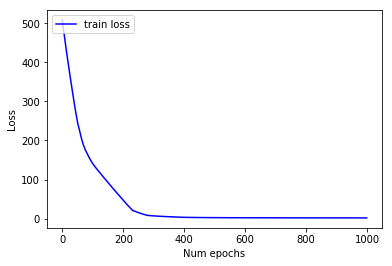

In [21]:
plt.plot(epochs, losses_log_reg_9, 'b', label="train loss");
plt.legend(loc='upper left');
plt.ylabel("Loss");
plt.xlabel("Num epochs");

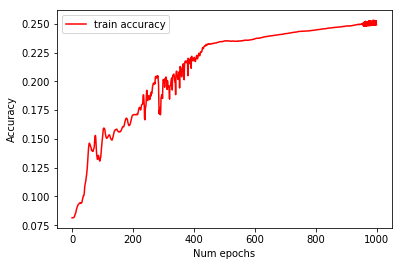

In [22]:
plt.plot(epochs, accuracies_log_reg_9, 'r', label="train accuracy");
plt.legend(loc='upper left');
plt.ylabel("Accuracy");
plt.xlabel("Num epochs");

### Getting user features

In [23]:
X_users = []
users_mappings = {}
with open('yelp_academic_dataset_user.json', 'r') as f:
    for i, line in enumerate(f):
        feature_vector = []
        d = json.loads(line)
        user_id = d['user_id'].encode('utf-8') 
        feature_vector.append(int(d['useful']))
        feature_vector.append(int(d['funny']))
        feature_vector.append(int(d['cool']))
        feature_vector.append(int(d['fans']))
        feature_vector.append(int(d['average_stars']))
        feature_vector.append(int(d['compliment_hot']))
        feature_vector.append(int(d['compliment_more']))
        feature_vector.append(int(d['compliment_profile']))
        feature_vector.append(int(d['compliment_cute']))
        feature_vector.append(int(d['compliment_list']))
        feature_vector.append(int(d['compliment_note']))
        feature_vector.append(int(d['compliment_plain']))
        feature_vector.append(int(d['compliment_cool']))
        feature_vector.append(int(d['compliment_funny']))
        feature_vector.append(int(d['compliment_writer']))
        feature_vector.append(int(d['compliment_photos']))
        X_users.append(feature_vector)
        users_mappings[user_id] = i

### Creating the adjacency matrix

In [24]:
business_to_user = {}

with open('yelp_academic_dataset_review.json', 'r') as f:
    for i, line in enumerate(f):
        d = json.loads(line)
        user_id = d['user_id'].encode('utf-8') 
        business_id = d['business_id'].encode('utf-8') 
        stars = int(d['stars'])
        if business_id in business_to_user:
            business_to_user[business_id].append((user_id, stars))
        else:
            business_to_user[business_id] = [(user_id, stars)]

### Define the aggregators

In [43]:
class Aggregator(nn.Module):
    def __init__(self, features_business, features_users): 
        super(Aggregator, self).__init__()
        self.features_business = features_business
        self.features_users = features_users
        
    def forward(self, nodes, neighbors):
        all_users = list(set.union(*neighbors))
        all_users_reindexed = {user:idx for idx,user in enumerate(all_users)}
        num_unique_users = len(all_users)
        num_businesses = len(neighbors)
        
        local_adj_m = Variable(torch.zeros(num_businesses, num_unique_users))
        column_indices = [all_users_reindexed[n] for neighborhood in neighbors for n in neighborhood]   
        row_indices = [business for business in range(num_businesses) for user in range(len(neighbors[business]))]
        local_adj_m[row_indices, column_indices] = 1
        neighbors_sum = local_adj_m.sum(1, keepdim=True) + 1e-7
        local_adj_m = local_adj_m.div(neighbors_sum)
        neighborhood_embeddings = self.features_users(torch.LongTensor(all_users))
        neighborhood_aggregation = local_adj_m.mm(neighborhood_embeddings)
        return neighborhood_aggregation

### Define the encoders

In [26]:
class Encoder(nn.Module):
    def __init__(self, features_business, features_users, feat_dim_users, feat_dim_business,
            embed_dim, adj_lists, aggregator): 
        super(Encoder, self).__init__()

        self.features_business = features_business
        self.features_users = features_users
        self.feat_dim_users = feat_dim_users
        self.feat_dim_business = feat_dim_business
        self.adj_lists = adj_lists
        self.aggregator = aggregator
        self.embed_dim = embed_dim
        self.weight = nn.Parameter(
                torch.FloatTensor(embed_dim, self.feat_dim_users + self.feat_dim_business))
        init.xavier_uniform(self.weight)

    def forward(self, nodes):
        neigh_feats = self.aggregator.forward(nodes, [self.adj_lists[int(node)] for node in nodes])
        self_feats = self.features_business(torch.LongTensor(nodes))
        combined = torch.cat([self_feats, neigh_feats], dim=1)
        combined = F.relu(self.weight.mm(combined.t()))
        return combined

### GCN Model

In [47]:
class GCN(nn.Module):

    def __init__(self, features_business, features_users, adj_lists, num_classes):
        super(GCN, self).__init__()
        self.num_classes = num_classes
        self.feat_dim_users = 16
        self.feat_dim_business = 24
        self.embed_dim = 128
        self.aggregator = Aggregator(features_business, features_users)
        self.encoder = Encoder(features_business, features_users, self.feat_dim_users, self.feat_dim_business, self.embed_dim, adj_lists, self.aggregator)
        self.loss_fn = nn.CrossEntropyLoss()
        self.weight = nn.Parameter(torch.FloatTensor(self.num_classes, self.encoder.embed_dim))
        init.xavier_uniform(self.weight)

    def forward(self, nodes):
        node_embs = self.encoder(nodes)
        scores = self.weight.mm(node_embs)
        return scores.t()

    def loss(self, pred, labels):
        return self.loss_fn(pred, labels)

### Setup for training loop

In [28]:
X_business = torch.from_numpy(np.array(X_train)).float()
y_business = torch.from_numpy(np.array(y_train)).float().squeeze()
X_users = torch.from_numpy(np.array(X_users)).float()
print(X_business.shape)
print(X_users.shape)
print(y_business.shape)
print("Feature dimension business: " , len(X_train[0]))
print("Feature dimension users: " , len(X_users[0]))
print(torch.min(y_business), torch.max(y_business))

torch.Size([146526, 24])
torch.Size([1518169, 16])
torch.Size([146526])
('Feature dimension business: ', 24)
('Feature dimension users: ', 16)
(tensor(0.), tensor(8.))


In [29]:
def normalize(x):
    x_normed = x / (x.max(0, keepdim=True)[0] + 1e-7)
    return x_normed

In [30]:
X_business_normalized = normalize(X_business)
X_users_normalized = normalize(X_users)

In [33]:
f1_scores = []
np.random.seed(1)
random.seed(1)
num_businesses = len(X_train)
num_users = len(X_users)
adj_lists = {}
feat_dim_business = len(X_train[0])
feat_dim_users = len(X_users[0])

for business_id, users_rev in business_to_user.iteritems():
    if business_id in business_mappings:
        adj_lists[business_mappings[business_id]] = set([users_mappings[k[0]] for k in users_rev if k[1] > 3])
print(len(adj_lists))

features_business = nn.Embedding(num_businesses, feat_dim_business)
features_business.weight = nn.Parameter(X_business_normalized, requires_grad=False)
    
features_users = nn.Embedding(num_users, feat_dim_users)
features_users.weight = nn.Parameter(X_users_normalized, requires_grad=False)

rand_indices = np.random.permutation(num_businesses)
num_train = int(num_businesses * 0.9)
train = list(rand_indices[:num_train])
val = list(rand_indices[num_train:])

162807


### Main train loop

In [57]:
gcn = GCN(features_business, features_users, adj_lists, num_classes=9)
lossess_gcn_09 = []
accuracies_gcn_09 = []
epoch_lossess_gcn_09 = []
optimizer = torch.optim.SGD(filter(lambda p : p.requires_grad, gcn.parameters()), lr=0.1)
labels = np.array(y_train)
y_train_tensor = torch.LongTensor(labels)
for i in range(50):
    #print("Epoch: ", i)
    num_correct = 0
    num_total = 0
    loss_sum = []
    for batch in range(8*16):
        start_time = time.time()
        batch_nodes = train[1024*batch:1024*(batch+1)]
        optimizer.zero_grad()
        y_pred = gcn(batch_nodes)
        loss = gcn.loss(y_pred, y_train_tensor[batch_nodes])
        lossess_gcn_09.append(loss.item())
        loss.backward()
        optimizer.step()
        end_time = time.time()
        batch_time = end_time - start_time
        #if batch % 50 == 0:
        pred = torch.max(y_pred, 1)[1].float()
        num_correct += (pred == y_train_tensor[batch_nodes].float()).sum().item()
        num_total += len(batch_nodes)
        loss_sum.append(loss.item())
    acc = (num_correct*1.0) / num_total
    avg_loss = np.mean(loss_sum)
    epoch_lossess_gcn_09.append(avg_loss)
    accuracies_gcn_09.append(acc)
    print("Epoch:", i, "Loss: ", avg_loss, "Batch time: ", batch_time, "Train accuracy: ", acc)

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:15: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  from ipykernel import kernelapp as app
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  del sys.path[0]


('Epoch:', 0, 'Loss: ', 1.9595418209210038, 'Batch time: ', 0.19217705726623535, 'Train accuracy: ', 0.23342132568359375)
('Epoch:', 1, 'Loss: ', 1.9112467635422945, 'Batch time: ', 0.21561884880065918, 'Train accuracy: ', 0.24849700927734375)
('Epoch:', 2, 'Loss: ', 1.9026440903544426, 'Batch time: ', 0.2077009677886963, 'Train accuracy: ', 0.25183868408203125)
('Epoch:', 3, 'Loss: ', 1.8971605654805899, 'Batch time: ', 0.23282313346862793, 'Train accuracy: ', 0.25460052490234375)
('Epoch:', 4, 'Loss: ', 1.8932573674246669, 'Batch time: ', 0.18024802207946777, 'Train accuracy: ', 0.25647735595703125)
('Epoch:', 5, 'Loss: ', 1.8902890253812075, 'Batch time: ', 0.19292807579040527, 'Train accuracy: ', 0.25731658935546875)
('Epoch:', 6, 'Loss: ', 1.8879226427525282, 'Batch time: ', 0.19065594673156738, 'Train accuracy: ', 0.25809478759765625)
('Epoch:', 7, 'Loss: ', 1.8859784193336964, 'Batch time: ', 0.20186901092529297, 'Train accuracy: ', 0.25936126708984375)
('Epoch:', 8, 'Loss: ', 1

In [51]:
print("Num train datapoints: ", len(train))
print("Num val datapoints: ", len(val))

('Num train datapoints: ', 131873)
('Num val datapoints: ', 14653)


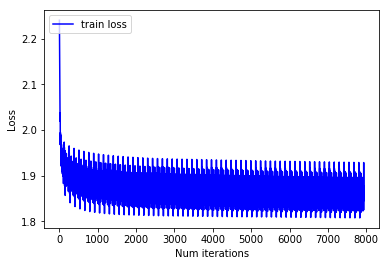

In [54]:
epochs = [i for i in range(7936)]
plt.plot(epochs, lossess_gcn_09, 'b', label="train loss");
plt.legend(loc='upper left');
plt.ylabel("Loss");
plt.xlabel("Num iterations");

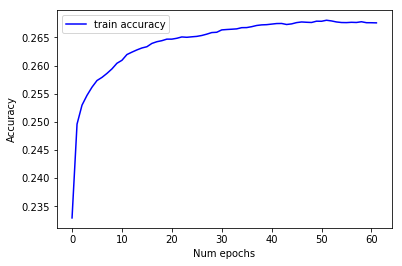

In [56]:
epochs = [i for i in range(62)]
plt.plot(epochs, accuracies_gcn_09, 'b', label="train accuracy");
plt.legend(loc='upper left');
plt.ylabel("Accuracy");
plt.xlabel("Num epochs");

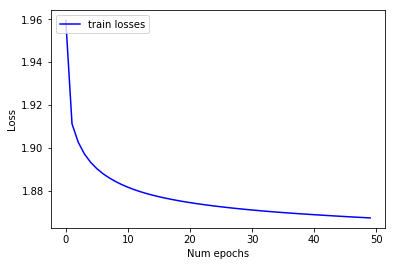

In [59]:
epochs = [i for i in range(50)]
plt.plot(epochs, epoch_lossess_gcn_09, 'b', label="train losses");
plt.legend(loc='upper left');
plt.ylabel("Loss");
plt.xlabel("Num epochs");

In [60]:
X_test_tensor = torch.from_numpy(np.array(X_test)).float()
y_test_tensor = torch.from_numpy(np.array(y_test)).float().squeeze()
y_pred = model(X_test_tensor)
pred = torch.max(y_pred, 1)[1].float()
accuracy = (pred == y_test_tensor).float().mean()
print("Accuracy on the test set: ", accuracy)

('Accuracy on the test set: ', tensor(0.2541))


## Trying with only 5 classes

In [64]:
X_business = []
y_business = []
print(len(stars))
business_mappings = {}
i = 0
for business_id, rating in stars.iteritems():
    business_mappings[business_id] = i
    X_business.append(get_feature_vector(business_id))
    y_business.append(int(rating))
    i += 1
y_cat = []
print(set(y_business))
sorted_y = sorted(set(y_business))
for val in y_business:
    y_cat.append(sorted_y.index(val))
print(min(y_cat), max(y_cat))

162807
set([1, 2, 3, 4, 5])
(0, 4)


In [65]:
X_train, X_test, y_train, y_test = train_test_split(X_business, y_cat, test_size=0.1, random_state=42)

### Logistic Regression

In [66]:
def logistic_regression(num_epochs = 1000):
    X_train_tensor = torch.from_numpy(np.array(X_train)).float()
    y_train_tensor = torch.from_numpy(np.array(y_train)).float().squeeze()
    losses = []
    accuracies = []
    D_in = 24
    D_out = 5
    epochs = [i for i in range(num_epochs)]
    model = torch.nn.Sequential(torch.nn.Linear(D_in, D_out))
    loss_fn = cross_entropy_loss = nn.CrossEntropyLoss()
    learning_rate = 0.001
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):
        y_pred = model(X_train_tensor)
        loss = loss_fn(y_pred, y_train_tensor.long())
        pred = torch.max(y_pred, 1)[1].float()
        accuracy = (pred == y_train_tensor).float().mean()
        losses.append(loss.item())
        accuracies.append(accuracy)
        f1 = f1_score(y_train, pred, average="micro")
        if epoch % 50 == 0:
            print("Epoch {}:, loss: {:.3f}, accuracy: {:.3f}, f1: {:.3f}".format(epoch, loss.item(), accuracy, f1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return model, epochs, losses, accuracies

In [69]:
model_log_reg5 = logistic_regression(1000)
X_test_tensor = torch.from_numpy(np.array(X_test)).float()
y_test_tensor = torch.from_numpy(np.array(y_test)).float().squeeze()
y_pred = model_log_reg(X_test_tensor)
pred = torch.max(y_pred, 1)[1].float()
accuracy = (pred == y_test_tensor).float().mean()
print("Accuracy on the test set: ", accuracy)

Epoch 0:, loss: 338.441, accuracy: 0.295, f1: 0.295
Epoch 50:, loss: 176.477, accuracy: 0.203, f1: 0.203
Epoch 100:, loss: 67.971, accuracy: 0.272, f1: 0.272
Epoch 150:, loss: 12.713, accuracy: 0.339, f1: 0.339
Epoch 200:, loss: 6.516, accuracy: 0.329, f1: 0.329
Epoch 250:, loss: 4.008, accuracy: 0.340, f1: 0.340
Epoch 300:, loss: 2.596, accuracy: 0.352, f1: 0.352
Epoch 350:, loss: 1.979, accuracy: 0.352, f1: 0.352
Epoch 400:, loss: 1.655, accuracy: 0.346, f1: 0.346
Epoch 450:, loss: 1.473, accuracy: 0.352, f1: 0.352
Epoch 500:, loss: 1.426, accuracy: 0.356, f1: 0.356
Epoch 550:, loss: 1.412, accuracy: 0.359, f1: 0.359
Epoch 600:, loss: 1.403, accuracy: 0.361, f1: 0.361
Epoch 650:, loss: 1.395, accuracy: 0.365, f1: 0.365
Epoch 700:, loss: 1.388, accuracy: 0.368, f1: 0.368
Epoch 750:, loss: 1.381, accuracy: 0.371, f1: 0.371
Epoch 800:, loss: 1.375, accuracy: 0.374, f1: 0.374
Epoch 850:, loss: 1.369, accuracy: 0.378, f1: 0.378
Epoch 900:, loss: 1.363, accuracy: 0.381, f1: 0.381
Epoch 950

In [71]:
def linear_regression(num_epochs = 1000):
    X_train_tensor = torch.from_numpy(np.array(X_train)).float()
    y_train_tensor = torch.from_numpy(np.array(y_train)).float().unsqueeze(1)
    losses = []
    accuracies = []
    D_in = 24
    D_out = 1
    epochs = [i for i in range(num_epochs)]
    model = torch.nn.Sequential(torch.nn.Linear(D_in, D_out))
    loss_fn = nn.MSELoss()
    learning_rate = 0.01
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):
        y_pred = model(X_train_tensor)
        loss = loss_fn(y_pred, y_train_tensor)
        pred = torch.round(y_pred * 2)/2
        accuracy = (pred == y_train_tensor).float().mean()
        losses.append(loss.item())
        accuracies.append(accuracy)
        #f1 = f1_score(y_train, pred, average="micro")
        if epoch % 200 == 0:
            print("Epoch {}:, loss: {:.3f}, accuracy: {:.3f}".format(epoch, loss.item(), accuracy))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return model

In [72]:
X_business = []
y_business = []
print(len(stars))
business_mappings = {}
i = 0
for business_id, rating in stars.iteritems():
    business_mappings[business_id] = i
    X_business.append(get_feature_vector(business_id))
    y_business.append(rating)
    i += 1

162807


In [73]:
X_train, X_test, y_train, y_test = train_test_split(X_business, y_business, test_size=0.1, random_state=42)

In [74]:
lin_reg = linear_regression(10000)
X_test_tensor = torch.from_numpy(np.array(X_test)).float()
y_test_tensor = torch.from_numpy(np.array(y_test)).float().unsqueeze(1)
y_pred = model(X_test_tensor)
pred = torch.round(y_pred * 2)/2
accuracy = (pred == y_test_tensor).float().mean()
print("Accuracy on the test set: ", accuracy)

Epoch 0:, loss: 727611.250, accuracy: 0.000
Epoch 200:, loss: 5.108, accuracy: 0.082
Epoch 400:, loss: 1.916, accuracy: 0.136
Epoch 600:, loss: 1.292, accuracy: 0.159
Epoch 800:, loss: 1.148, accuracy: 0.172
Epoch 1000:, loss: 1.087, accuracy: 0.179
Epoch 1200:, loss: 1.054, accuracy: 0.182
Epoch 1400:, loss: 1.035, accuracy: 0.184
Epoch 1600:, loss: 1.022, accuracy: 0.185
Epoch 1800:, loss: 1.011, accuracy: 0.186
Epoch 2000:, loss: 1.000, accuracy: 0.186
Epoch 2200:, loss: 0.990, accuracy: 0.188
Epoch 2400:, loss: 0.981, accuracy: 0.189
Epoch 2600:, loss: 0.971, accuracy: 0.190
Epoch 2800:, loss: 0.963, accuracy: 0.191
Epoch 3000:, loss: 0.954, accuracy: 0.192
Epoch 3200:, loss: 0.947, accuracy: 0.193
Epoch 3400:, loss: 0.940, accuracy: 0.194
Epoch 3600:, loss: 0.933, accuracy: 0.194
Epoch 3800:, loss: 0.928, accuracy: 0.195
Epoch 4000:, loss: 0.923, accuracy: 0.196
Epoch 4200:, loss: 0.918, accuracy: 0.196
Epoch 4400:, loss: 0.915, accuracy: 0.197
Epoch 4600:, loss: 0.912, accuracy: 

In [76]:
gcn = GCN(features_business, features_users, adj_lists, num_classes=5)
lossessgd1 = []
accuraciessgd1 = []
epoch_lossessgd1 = []
optimizer = torch.optim.SGD(filter(lambda p : p.requires_grad, gcn.parameters()), lr=0.1)
labels = np.array(y_train)
y_train_tensor = torch.LongTensor(labels)
for i in range(100):
    #print("Epoch: ", i)
    num_correct = 0
    num_total = 0
    loss_sum = []
    for batch in range(8*16):
        start_time = time.time()
        batch_nodes = train[1024*batch:1024*(batch+1)]
        optimizer.zero_grad()
        y_pred = gcn(batch_nodes)
        loss = gcn.loss(y_pred, y_train_tensor[batch_nodes])
        lossessgd1.append(loss.item())
        loss.backward()
        optimizer.step()
        end_time = time.time()
        batch_time = end_time - start_time
        #if batch % 50 == 0:
        pred = torch.max(y_pred, 1)[1].float()
        num_correct += (pred == y_train_tensor[batch_nodes].float()).sum().item()
        num_total += len(batch_nodes)
        loss_sum.append(loss.item())
    acc = (num_correct*1.0) / num_total
    avg_loss = np.mean(loss_sum)
    epoch_lossessgd1.append(avg_loss)
    accuraciessgd1.append(acc)
    print("Epoch:", i, "Loss: ", avg_loss, "Batch time: ", batch_time, "Train accuracy: ", acc)

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:15: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  from ipykernel import kernelapp as app
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  del sys.path[0]


RuntimeError: Assertion `cur_target >= 0 && cur_target < n_classes' failed.  at /Users/soumith/code/builder/wheel/pytorch-src/aten/src/THNN/generic/ClassNLLCriterion.c:93

In [ ]:
epochs = [i for i in range(12800)]
plt.plot(epochs, lossessgd07, 'b', label="train loss");
plt.legend(loc='upper left');
plt.ylabel("Loss");
plt.xlabel("Num iterations");

In [ ]:
epochs = [i for i in range(100)]
plt.plot(epochs, accuraciessgd07, 'b', label="train accuracy");
plt.legend(loc='upper left');
plt.ylabel("Accuracy");
plt.xlabel("Num epochs");

In [ ]:
epochs = [i for i in range(100)]
plt.plot(epochs, epoch_lossessgd07, 'b', label="train losses");
plt.legend(loc='upper left');
plt.ylabel("Loss");
plt.xlabel("Num epochs");